In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

1.8.0.dev20201128


Use some data

In [9]:
import pickle
for dataset in [#'biofam',
    'flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0].astype(int)
    print(dataset)
    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()}")

def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0]
    X=X.astype(int)

    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()} ==> d={X.max()+1}")
    d = X.max()+1
    return X, d

flare
	data shape: (1065, 13)
	range of X values: 0 -- 7
lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7
spect
	data shape: (187, 23)
	range of X values: 0 -- 1
tumor
	data shape: (339, 17)
	range of X values: 0 -- 3
votes
	data shape: (435, 17)
	range of X values: 0 -- 2


In [10]:
dataset = 'lymphography'
print("dataset:", dataset)
X,d = load_dataset(dataset)

D = 4
mps       = PosMPS(X, d, D, homogeneous=False)
mps_hom   = PosMPS(X, d, D, homogeneous=True)

rBorn     = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False) 
rBorn_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False) 

cBorn     = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False)
cBorn_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False)

rBorn_s   = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True) 
rBorn_s_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True) 

cBorn_s   = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True)
cBorn_s_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True)

models     = (rBorn, cBorn, rBorn_s, cBorn_s, mps)
models_hom = (rBorn_hom, cBorn_hom, rBorn_s_hom, cBorn_s_hom, mps_hom)
print("Initializing models:")
for model in (*models, *models_hom):
    print(f"\t{model.core.shape} model type: {model.name}")
    for p in model.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")

dataset: lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7 ==> d=8
Initializing models:
	torch.Size([19, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous
	torch.Size([19, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous
	torch.Size([19, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous + log_stability
	torch.Size([19, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous + log_stability
	torch.Size([19, 8, 4, 4]) model type: Positive MPS, Non-homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous
	torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous + log_stability
	torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous + log_stability
	torch.Size([8, 4, 4]) model type: Positive MPS, Homogeneous


In [11]:
def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
    trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.SGD(self.parameters(), **optim_kwargs)
    early_stopping_threshold = 0.0001 # min difference in epoch loss
    loss_values = [] # store by-epoch avg loss values
    print('╭───────────────────────────')
    print(f"│Training {self.name}.")
    av_batch_loss_running = -1000
    with tqdm(range(max_epochs), leave=True) as tepochs:
        for epoch in tepochs:
    #         print("epoch", epoch)
            batch_loss = []
            with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
                for batch in tepoch:
                    for p in self.parameters():
                        if torch.isnan(p).any():
                            print(" loss values:", *(f"{x:.3f}" for x in loss_values))
                            print("└────Stopped. Model weights contain a NaN value!")
                            if plot:
                                plt.plot(loss_values)
                                plt.show()
                            return loss_values
                    self.zero_grad()
                    neglogprob = 0
                    for i,x in enumerate(batch):
                        out = self(x)
                        neglogprob -= out
                    loss = neglogprob / len(batch)
                    loss.backward()
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())
                    with torch.no_grad():
                        batch_loss.append(loss.item())
    #                     n=5
    #                     if batch_idx % n == 0: # print every nth batch loss
    #                         print("\tbatch", batch_idx, "size", len(batch), "loss", loss.item())
            av_batch_loss = torch.Tensor(batch_loss).mean().item()
    #         print(f"ep{epoch} av_batch_loss\t {av_batch_loss}")
            loss_values.append(av_batch_loss)
            tepochs.set_postfix(av_batch_loss=av_batch_loss)
            if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
                print("└────Early stopping.")
                break
            av_batch_loss_running = av_batch_loss
    print(" loss values:", *(f"{x:.3f}" for x in loss_values))
    if plot:
        plt.plot(loss_values)
        plt.show()
    print('╰────────Finished─training──\n')
    return loss_values

# train(rBorn, X, batchsize=30, max_epochs = 10, lr=0.1)

╭───────────────────────────
│Training Born (torch.float32), Homogeneous.


└────Early stopping.

 loss values: 37.331 32.984 30.678 29.062 27.888 27.439 26.890 26.521 26.675 26.060 25.839 26.066 25.509 25.601 25.816 25.605 25.366 25.237 25.438 25.189 25.182 25.280 25.078 24.980 25.120 24.807 25.121 24.495 24.498 24.422 24.528 23.871 23.986 23.974 24.062 23.490 24.176 23.826 23.385 23.482 23.298 23.182 23.510 23.194 23.287 23.369 23.249 23.486 23.381 23.472 23.179 23.011 23.171 23.007 22.832 23.054 23.022 23.293 22.730 22.903 22.459 22.605 22.876 23.224 22.722 22.531 22.535 22.930 22.649 22.643 22.550 22.576 22.541 22.850 22.607 22.724 22.760 22.493 22.523 22.661 22.290 22.829 22.352 22.590 22.322 22.680 22.349 22.397 22.393 22.417 22.506 22.498 22.038 22.392 22.581 22.405 22.381 22.381
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Born (torch.float32), Homogeneous + log_stability.



 loss values: 34.833 31.547 29.527 28.252 27.756 27.091 26.265 26.103 25.858 25.684 25.613 25.498 25.155 25.099 24.952 25.014 25.108 24.871 24.549 24.247 25.045 24.018 24.409 24.100 24.470 24.070 24.095 23.729 23.910 23.378 23.294 23.177 23.388 23.243 22.861 23.186 23.126 22.949 22.585 22.669 22.813 22.631 22.372 22.351 22.094 22.382 21.984 21.992 22.196 22.088 22.270 22.195 21.971 22.012 21.776 22.028 21.683 21.662 21.958 21.838 21.782 21.834 22.008 21.886 22.154 21.478 21.632 21.362 21.699 21.292 21.214 21.211 21.458 21.605 21.335 21.183 21.461 21.571 21.459 21.509 21.138 21.208 21.094 21.249 21.460 21.067 21.222 21.311 21.114 20.952 21.230 21.133 21.017 20.991 20.960 20.876 21.063 21.204 20.915 20.767
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous + log_stability.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Positive MPS, Homogeneous.



 loss values: 36.522 33.435 31.674 30.259 29.166 28.230 27.978 27.285 26.959 26.476 26.533 26.161 26.333 26.073 25.825 25.626 25.591 25.563 24.957 25.513 24.889 25.090 24.644 24.820 24.254 24.733 24.720 24.473 24.013 24.036 23.916 24.170 23.790 23.534 23.700 23.647 23.515 23.528 23.564 23.215 22.962 23.366 23.251 23.216 23.026 23.086 23.068 23.095 23.026 23.174 23.023 23.114 22.632 22.848 22.693 22.864 22.579 23.028 22.960 23.155 23.178 22.764 22.525 22.947 22.683 22.851 22.631 22.561 22.858 23.120 22.641 22.518 22.476 22.666 22.427 22.523 22.441 22.592 22.553 22.441 22.478 22.370 22.546 22.456 22.483 22.943 22.663 22.837 22.463 22.470 22.673 22.358 22.706 22.473 22.589 22.225 22.548 22.594 22.456 22.304
╰────────Finished─training──



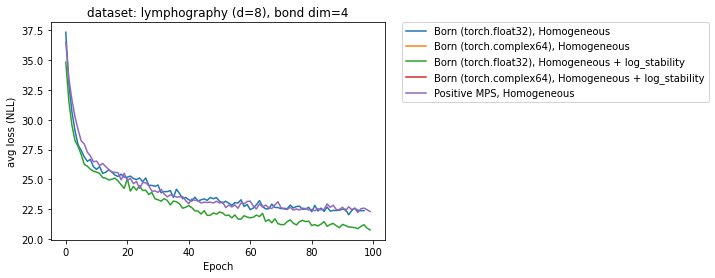

In [12]:
modelhom_loss_values={}
for model in models_hom:
    loss_values = train(model, X, batchsize=35, plot=False, max_epochs = 100, lr=0.02)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    modelhom_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous.



 loss values: 38.342 35.146 32.758 30.851 29.264 27.905 26.713 25.672 24.744 23.901 23.169 22.518 21.963 21.454 21.010 20.582 20.199 19.851 19.551 19.255 18.970 18.729 18.493 18.281 18.082 17.900 17.741 17.580 17.433 17.307 17.171 17.040 16.935 16.846 16.733 16.660 16.543 16.461 16.414 16.319 16.255 16.199 16.132 16.085 16.032 15.988 15.930 15.888 15.858 15.834 15.781 15.772 15.723 15.672 15.666 15.655 15.605 15.571 15.552 15.540 15.522 15.495 15.484 15.476 15.427 15.435 15.403 15.380 15.382 15.361 15.354 15.328 15.321 15.309 15.312 15.294 15.266 15.256 15.243 15.227 15.224 15.203 15.203 15.186 15.185 15.188 15.173 15.157 15.141 15.140 15.133 15.117 15.120 15.123 15.107 15.092 15.087 15.079 15.075 15.054
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous + log_stability.



 loss values: 36.953 33.643 31.054 28.994 27.398 25.994 24.702 23.697 22.876 21.856 21.226 20.434 19.920 19.317 18.874 18.447 18.102 17.736 17.404 17.152 16.815 16.591 16.429 16.161 15.938 15.791 15.620 15.443 15.285 15.147 15.044 14.905 14.793 14.681 14.596 14.558 14.402 14.329 14.222 14.160 14.085 14.031 13.992 13.935 13.853 13.820 13.751 13.717 13.668 13.610 13.571 13.529 13.515 13.466 13.434 13.387 13.340 13.321 13.311 13.268 13.239 13.210 13.167 13.168 13.138 13.120 13.069 13.101 13.034 13.008 13.010 12.975 12.972 12.924 12.907 12.891 12.881 12.870 12.839 12.812 12.804 12.782 12.764 12.746 12.734 12.733 12.708 12.685 12.677 12.656 12.651 12.618 12.621 12.604 12.592 12.562 12.562 12.553 12.528 12.526
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous + log_stability.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Positive MPS, Non-homogeneous.



 loss values: 37.381 34.589 32.234 30.227 28.487 26.968 25.641 24.482 23.486 22.599 21.820 21.147 20.542 20.021 19.569 19.171 18.810 18.494 18.217 17.977 17.729 17.536 17.354 17.207 17.052 16.925 16.777 16.663 16.548 16.457 16.368 16.281 16.204 16.131 16.080 15.999 15.947 15.890 15.827 15.776 15.731 15.699 15.649 15.616 15.580 15.541 15.495 15.461 15.426 15.410 15.385 15.360 15.322 15.305 15.273 15.273 15.229 15.231 15.179 15.163 15.154 15.140 15.111 15.093 15.076 15.055 15.052 15.025 15.022 15.000 14.989 14.990 14.978 14.956 14.945 14.945 14.926 14.905 14.899 14.902 14.876 14.878 14.854 14.867 14.842 14.841 14.831 14.823 14.807 14.803 14.800 14.788 14.781 14.792 14.758 14.745 14.733 14.743 14.722 14.709
╰────────Finished─training──



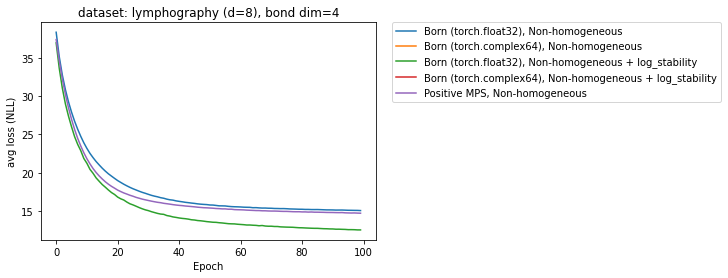

In [13]:
model_loss_values={}
for model in models:
    loss_values = train(model, X, batchsize=30, plot=False, max_epochs = 100, lr=0.1)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

---------

In [57]:
# testing complex functions
real = torch.tensor([[1, 2],[2, 1]], dtype=torch.float32)
imag = torch.tensor([[3, 4],[1, 2]], dtype=torch.float32)
z = torch.complex(real, imag)
# z = torch.randn(2,2, dtype=torch.cfloat)
z.requires_grad=True
b = (2.7j*z + 3.4*z + 18)
L = torch.einsum('ij,ji,ij,ji->',b,b,b,b).abs()
L.backward()

print("z:\n",z,'\n', sep='')
print("loss grad_fn:\n", L.grad_fn,'\n', sep='')
print("z.grad:\n", z.grad,'\n', sep='')

def infnorm(tensor):
#     return torch.max(torch.sum(abs(tensor), dim=-1))
    print(tensor.abs().max())
    return torch.linalg.norm(tensor, ord=float('inf')).real

norm = infnorm
print(norm(z.grad))
print(norm(z.grad[0]))

z:
tensor([[1.+3.j, 2.+4.j],
        [2.+1.j, 1.+2.j]], requires_grad=True)

loss grad_fn:

z.grad:
tensor([[103476.6328-38667.7930j, 224180.9375+59425.4219j],
        [219980.8125-67495.4922j, 105286.0781+37877.9062j]])

tensor(231923.4219)
tensor(342388.8438)
tensor(231923.4219)
tensor(231923.4219)


In [20]:
print(matnorm(z))
print(torch.max(torch.sum(abs(z), dim=1)))

tensor(7.6344+0.j, grad_fn=<CopyBackwards>)
tensor(7.6344, grad_fn=<MaxBackward1>)
